# Assignment (Part 1)

## Lecture 4 — Data (BCRP + Yahoo) + Plots + Stats + VaR 

Reproduce the key parts of the lecture notebook using:

- **Peru (BCRP API)**: `PD04637PD`, `PD04639PD`, `PD04704XD`, `PD04701XD`  
  *(FX + commodities exactly as in the notebook)*
- **USA (yfinance)**: `SPY`, `TLT`, `GLD`

**Deliverables**
- Multiple **plots** (including **one with annotations**)  
- A **summary statistics table**  
- **Historical 95% VaR** for a **60/40 portfolio** (SPY/TLT)

In [2]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# For fetching real financial data
import yfinance as yf

# Date handling
from datetime import datetime, timedelta

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

print("All libraries imported successfully!")

All libraries imported successfully!


1. Build (and display) the **BCRPData API URL** that requests the 4 series used in the notebook.  


In [3]:
# --- Build BCRP API URL for the 4 selected series ---

base_url = "https://estadisticas.bcrp.gob.pe/estadisticas/series/api"

# BCRP series used in the notebook
series_codes = [
    "PD04637PD",  # USD/PEN interbank
    "PD04639PD",  # USD/PEN SBS
    "PD04704XD",  # Gold price (USD/oz)
    "PD04701XD"   # Copper price (USD/lb)
]

# Join series codes as required by the API
codes_param = "-".join(series_codes)

# Request parameters
response_format = "json"
start_date = "2021-01-01"
end_date = "2025-12-31"
language = "esp"

# Build the API URL
bcrp_api_url = (
    f"{base_url}/{codes_param}/{response_format}/"
    f"{start_date}/{end_date}/{language}"
)

# Display the URL
print("BCRP API URL:")
print(bcrp_api_url)

BCRP API URL:
https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PD04637PD-PD04639PD-PD04704XD-PD04701XD/json/2021-01-01/2025-12-31/esp


2. Download those series and build a **tidy** table: `date`, `series`, `value`.  


In [4]:
import requests
import pandas as pd
import numpy as np

# --- Download data from previously built URL ---
r = requests.get(bcrp_api_url, timeout=30)
r.raise_for_status()
data = r.json()

# --- Build wide DataFrame ---
rows = []
for p in data.get("periods", []):
    if not isinstance(p.get("values"), list):
        continue

    values = p["values"]
    values = (values + [None] * len(series_codes))[:len(series_codes)]
    values = [np.nan if v in ("n.d.", "nd", "N.D.") else v for v in values]

    rows.append([p["name"]] + values)

df_wide = pd.DataFrame(rows, columns=["date"] + series_codes)

# --- Robust BCRP date parsing ---
month_map = {
    "Ene": "Jan", "Feb": "Feb", "Mar": "Mar", "Abr": "Apr",
    "May": "May", "Jun": "Jun", "Jul": "Jul", "Ago": "Aug",
    "Set": "Sep", "Sep": "Sep", "Oct": "Oct", "Nov": "Nov", "Dic": "Dec"
}

df_wide["date"] = (
    df_wide["date"]
    .astype(str)
    .replace(month_map, regex=True)
    .str.replace(".", "", regex=False)
)

df_wide["date"] = pd.to_datetime(df_wide["date"], format="%d%b%y")

# --- Numeric conversion ---
df_wide[series_codes] = df_wide[series_codes].apply(pd.to_numeric, errors="coerce")

# --- Tidy (long) format ---
df_tidy = (
    df_wide
    .melt("date", var_name="series", value_name="value")
    .sort_values(["date", "series"])
    .reset_index(drop=True)
)

print(df_tidy.head())
print(df_tidy.tail())

        date     series   value
0 2021-01-01  PD04637PD     NaN
1 2021-01-01  PD04639PD     NaN
2 2021-01-01  PD04701XD 1891.10
3 2021-01-01  PD04704XD  351.15
4 2021-01-04  PD04637PD    3.62
           date     series   value
5211 2025-12-30  PD04704XD  567.53
5212 2025-12-31  PD04637PD    3.36
5213 2025-12-31  PD04639PD    3.36
5214 2025-12-31  PD04701XD 4339.49
5215 2025-12-31  PD04704XD  567.53


3. Clean to **wide format** with columns: `fx_interbank`, `fx_sbs`, `gold`, `copper` (as in the notebook).  


In [5]:
# --- Map series codes to readable names ---
series_map = {
    "PD04637PD": "fx_interbank",
    "PD04639PD": "fx_sbs",
    "PD04704XD": "copper",
    "PD04701XD": "gold",
}

# Rename series
df_tidy["series"] = df_tidy["series"].map(series_map)

# Pivot to wide format
df_wide_clean = (
    df_tidy
    .pivot(index="date", columns="series", values="value")
    .sort_index()
    .reset_index()
)

print(df_wide_clean.head())
print(df_wide_clean.tail())

series       date  copper  fx_interbank  fx_sbs    gold
0      2021-01-01  351.15           NaN     NaN 1891.10
1      2021-01-04  359.18          3.62    3.62 1943.20
2      2021-01-05  358.97          3.63    3.63 1940.35
3      2021-01-06  368.75          3.62    3.62 1931.95
4      2021-01-07  364.53          3.62    3.62 1920.10
series       date  copper  fx_interbank  fx_sbs    gold
1299   2025-12-25  555.79           NaN     NaN 4479.42
1300   2025-12-26  555.79           NaN     NaN 4533.21
1301   2025-12-29  558.19          3.37    3.36 4332.35
1302   2025-12-30  567.53          3.36    3.36 4339.49
1303   2025-12-31  567.53          3.36    3.36 4339.49


4. Download `SPY`, `TLT`, `GLD` from yfinance and build: `date`, `ticker`, `close`.  


In [6]:
START = "2021-01-01"
END = "2025-12-31"

tickers = ["SPY", "TLT", "GLD"]

prices = yf.download(tickers,start=START,end=END,auto_adjust=True,progress=False)

df_tidy = (prices["Close"].reset_index().melt(id_vars="Date",
                                              var_name="ticker",
                                              value_name="close").rename(columns={"Date": "date"})
                                                                 .dropna(subset=["close"])
                                                                 .sort_values(["ticker", "date"])
                                                                 .reset_index(drop=True))

print(df_tidy.head())
print(df_tidy.tail())

        date ticker  close
0 2021-01-04    GLD 182.33
1 2021-01-05    GLD 182.87
2 2021-01-06    GLD 179.90
3 2021-01-07    GLD 179.48
4 2021-01-08    GLD 173.34
           date ticker  close
3757 2025-12-23    TLT  87.50
3758 2025-12-24    TLT  88.03
3759 2025-12-26    TLT  87.74
3760 2025-12-29    TLT  88.07
3761 2025-12-30    TLT  87.86


5. Compute **daily returns** by ticker (`ret`) and validate there are **no inf values**.  


In [7]:
# Calcular retorno diario por ticker
df_tidy["ret"] = df_tidy.groupby("ticker")["close"].pct_change()

# Reemplazar posibles inf o -inf por NaN
df_tidy["ret"].replace([np.inf, -np.inf], np.nan, inplace=True)

# Opcional: eliminar filas donde ret sea NaN (primer día de cada ticker)
df_tidy_clean = df_tidy.dropna(subset=["ret"]).reset_index(drop=True)

# Validación: asegurar que no queden inf
assert not np.isinf(df_tidy_clean["ret"]).any(), "Todavía hay valores infinitos 😱"

print(df_tidy_clean.head())
print(df_tidy_clean.tail())

        date ticker  close   ret
0 2021-01-05    GLD 182.87  0.00
1 2021-01-06    GLD 179.90 -0.02
2 2021-01-07    GLD 179.48 -0.00
3 2021-01-08    GLD 173.34 -0.03
4 2021-01-11    GLD 173.00 -0.00
           date ticker  close   ret
3754 2025-12-23    TLT  87.50  0.00
3755 2025-12-24    TLT  88.03  0.01
3756 2025-12-26    TLT  87.74 -0.00
3757 2025-12-29    TLT  88.07  0.00
3758 2025-12-30    TLT  87.86 -0.00


6. *(Quantities)* Compare FX levels in Peru: produce a **plot** and a short comment.  


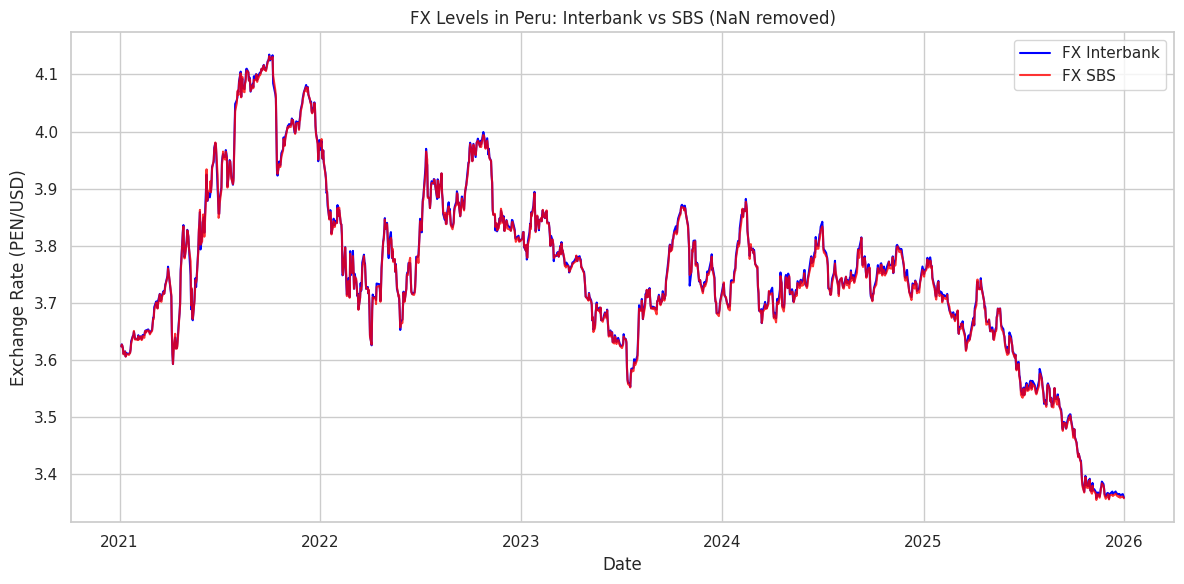

Promedio FX Interbank: 3.7553
Promedio FX SBS: 3.7534
Comentario: Ambos tipos de cambio siguen un patrón muy cercano y con pequeñas diferencias. Tras alcanzar un máximo en 2021, se ha mantenido una tendencia decreciente en el tipo de cambio.


In [8]:
# Configuración de estilo
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# ── Filtrar filas sin NaN en fx_interbank y fx_sbs ─────────────────────────────
df_plot = df_wide_clean.dropna(subset=["fx_interbank", "fx_sbs"])

# ── Plot FX levels in Peru ─────────────────────────────────────────────────────
plt.plot(df_plot["date"], df_plot["fx_interbank"], label="FX Interbank", color="blue")
plt.plot(df_plot["date"], df_plot["fx_sbs"], label="FX SBS", color="red", alpha=0.8)

# Etiquetas y título
plt.xlabel("Date")
plt.ylabel("Exchange Rate (PEN/USD)")
plt.title("FX Levels in Peru: Interbank vs SBS (NaN removed)")
plt.legend()
plt.tight_layout()

plt.show()

interbank_mean = df_plot["fx_interbank"].mean()
sbs_mean = df_plot["fx_sbs"].mean()

print(f"Promedio FX Interbank: {interbank_mean:.4f}")
print(f"Promedio FX SBS: {sbs_mean:.4f}")
print("Comentario: Ambos tipos de cambio siguen un patrón muy cercano y con pequeñas diferencias. Tras alcanzar un máximo en 2021, se ha mantenido una tendencia decreciente en el tipo de cambio.")

7. *(Proportions)* Compute the **share of positive-return days** by ticker (USA).  


In [9]:
# ── Crear columna booleana: True si retorno > 0 ───────────────────────────────
df_tidy_clean["positive"] = df_tidy_clean["ret"] > 0

# ── Calcular la proporción de días positivos por ticker ────────────────────────
positive_share = (
    df_tidy_clean
    .groupby("ticker")["positive"]
    .mean()  # La media de True/False = proporción
    .reset_index()
    .rename(columns={"positive": "share_positive_days"})
)

# ── Mostrar resultado
print(positive_share)

  ticker  share_positive_days
0    GLD                 0.54
1    SPY                 0.55
2    TLT                 0.49


8. Plot that share as a **bar chart** and add **labels above each bar** (`annotate`).  


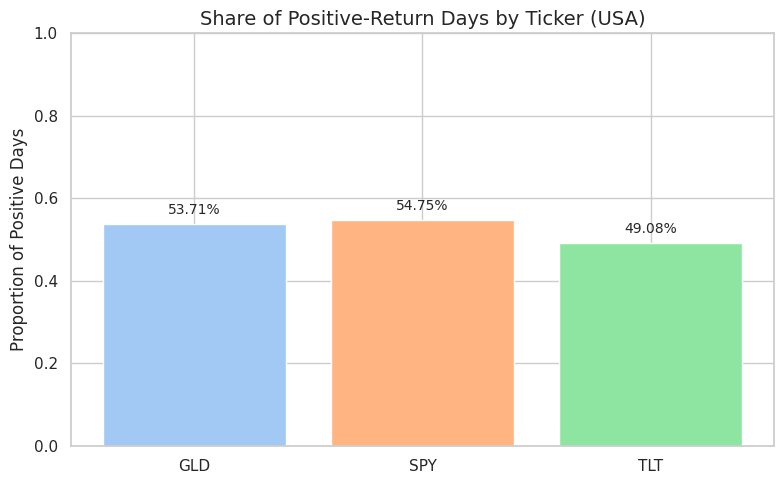

In [10]:
# ── Estilo seaborn ───────────────────────────────────────────────────────
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 5))

# ── Bar chart ───────────────────────────────────────────────────────────
bars = ax.bar(
    positive_share["ticker"],
    positive_share["share_positive_days"],
    color=sns.color_palette("pastel", len(positive_share))
)

# ── Etiquetas arriba de cada barra ──────────────────────────────────────
for bar in bars:
    height = bar.get_height()
    ax.annotate(
        f'{height:.2%}',            # Mostrar en porcentaje
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 5),              # Desplazamiento vertical
        textcoords="offset points",
        ha='center',
        va='bottom',
        fontsize=10
    )

# ── Título y etiquetas ─────────────────────────────────────────────────
ax.set_title("Share of Positive-Return Days by Ticker (USA)", fontsize=14)
ax.set_ylabel("Proportion of Positive Days")
ax.set_ylim(0, 1)  # Asegura eje Y entre 0 y 1

plt.tight_layout()
plt.show()

9. *(Distributions)* Compare the distribution of **Peru Gold** vs **GLD** (histogram).  


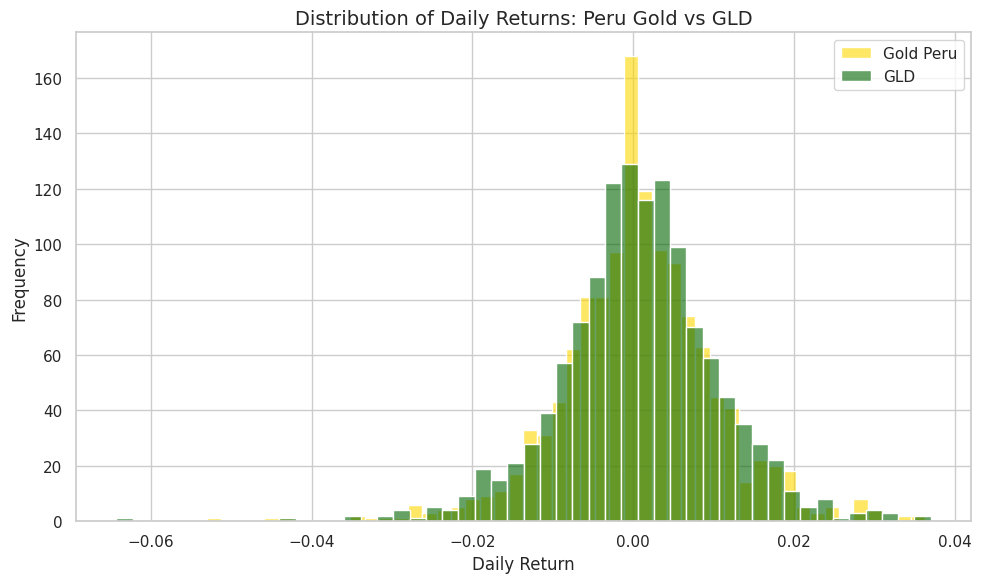

In [11]:
# ── Calcular retornos diarios ─────────────────────────────────────────────
ret_gold_peru = df_wide_clean["gold"].pct_change().dropna()
ret_gld = df_tidy_clean.loc[df_tidy_clean["ticker"] == "GLD", "ret"].dropna()

# ── Configuración seaborn ────────────────────────────────────────────────
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,6))

# ── Histograma retornos Oro Perú ─────────────────────────────────────────
sns.histplot(ret_gold_peru, color="gold", label="Gold Peru", bins=50, alpha=0.6, kde=False)

# ── Histograma retornos GLD ─────────────────────────────────────────────
sns.histplot(ret_gld, color="darkgreen", label="GLD", bins=50, alpha=0.6, kde=False)

# ── Etiquetas y título ───────────────────────────────────────────────────
plt.title("Distribution of Daily Returns: Peru Gold vs GLD", fontsize=14)
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# ── Se opta por los retornos, ya que el valor Gold Perú es muy superior al GLD como se verá en el segundo histograma.

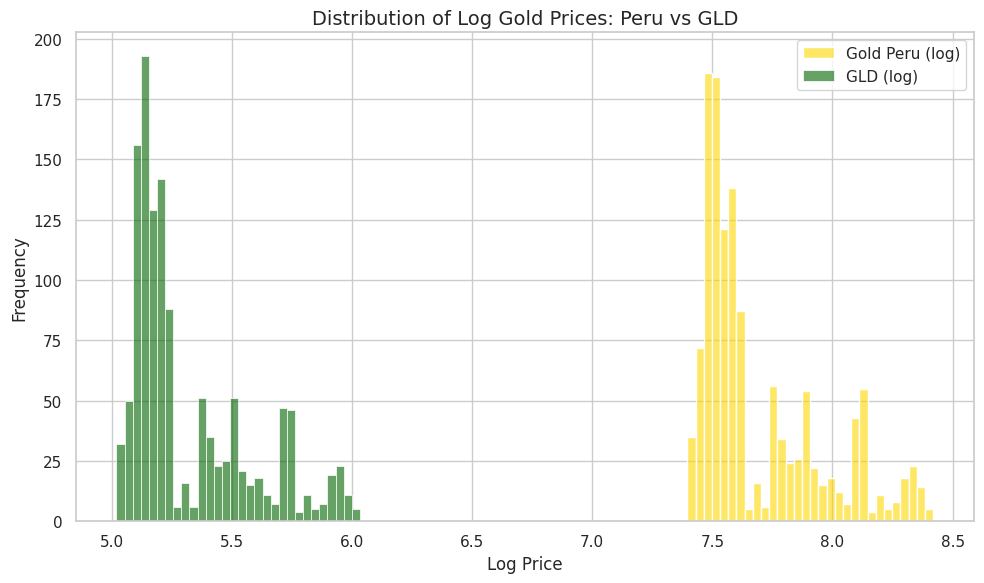

In [12]:
# ── Extraer series relevantes y convertir a logaritmos ───────────────────
gold_peru_log = np.log(df_wide_clean["gold"].dropna())       # Oro en Perú (BCRP)
gld_log       = np.log(df_tidy_clean.loc[df_tidy_clean["ticker"] == "GLD", "close"].dropna())

# ── Configuración seaborn ────────────────────────────────────────────────
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,6))

# ── Histograma Oro Perú (log) ──────────────────────────────────────────
sns.histplot(gold_peru_log, color="gold", label="Gold Peru (log)", bins=30, alpha=0.6, kde=False)

# ── Histograma GLD (log) ──────────────────────────────────────────────
sns.histplot(gld_log, color="darkgreen", label="GLD (log)", bins=30, alpha=0.6, kde=False)

# ── Etiquetas y título ───────────────────────────────────────────────────
plt.title("Distribution of Log Gold Prices: Peru vs GLD", fontsize=14)
plt.xlabel("Log Price")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

10. Add an **ECDF** (if used in the notebook) and comment on what changes vs the histogram.  


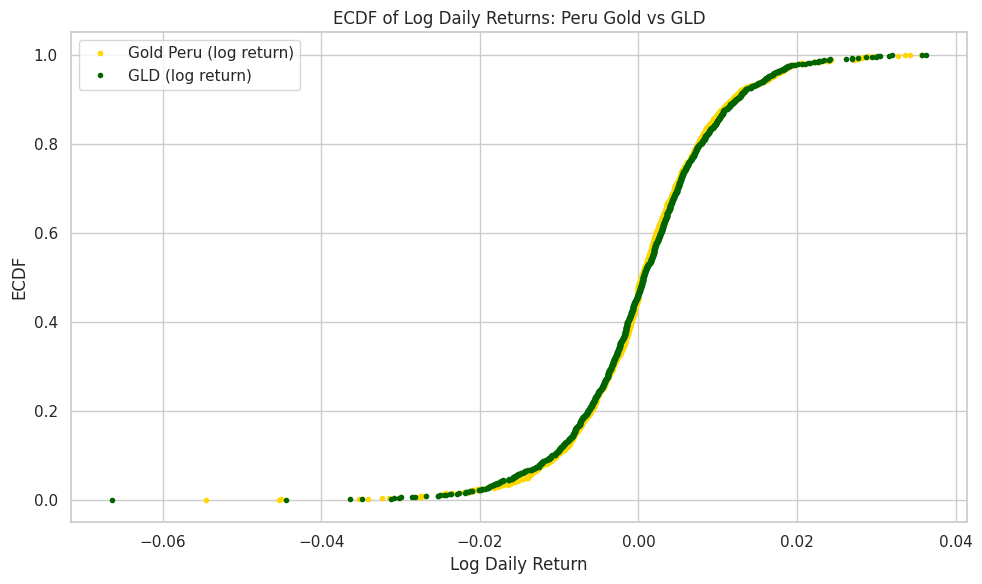

In [13]:
# ── Calcular retornos logarítmicos ──────────────────────────────────────
# Oro Perú
gold_prices = df_wide_clean["gold"].dropna()
gold_ret_log = np.log(gold_prices / gold_prices.shift(1)).dropna()

# GLD
gld_prices = df_tidy_clean.loc[df_tidy_clean["ticker"] == "GLD", "close"].dropna()
gld_ret_log = np.log(gld_prices / gld_prices.shift(1)).dropna()

# ── Función ECDF ─────────────────────────────────────────────────────────
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

# ── Calcular ECDFs ───────────────────────────────────────────────────────
x_gold, y_gold = ecdf(gold_ret_log)
x_gld, y_gld   = ecdf(gld_ret_log)

# ── Graficar ─────────────────────────────────────────────────────────────
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,6))

plt.plot(x_gold, y_gold, marker='.', linestyle='none', color='gold', label='Gold Peru (log return)')
plt.plot(x_gld, y_gld, marker='.', linestyle='none', color='darkgreen', label='GLD (log return)')

plt.xlabel("Log Daily Return")
plt.ylabel("ECDF")
plt.title("ECDF of Log Daily Returns: Peru Gold vs GLD")
plt.legend()
plt.tight_layout()
plt.show()

11. *(Relationships)* Build `FX_change` and relate it to `SPY_ret` (scatter plot).  


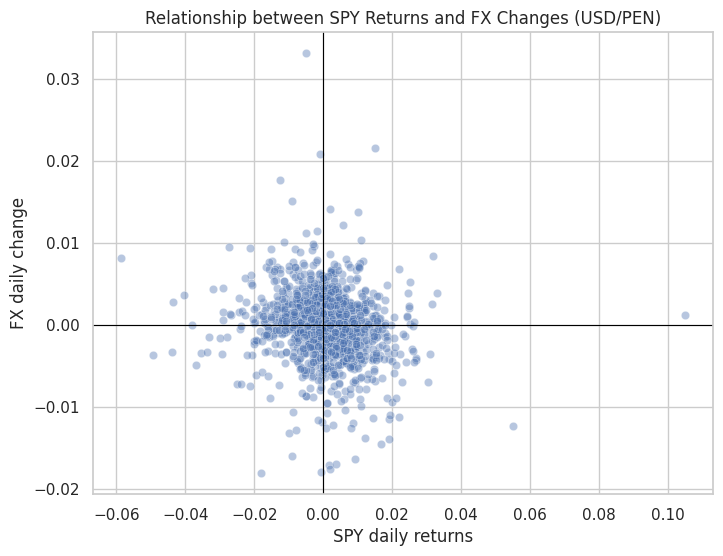

In [14]:
# --- FX daily change (returns) ---
fx = (
    df_wide_clean[["date", "fx_interbank"]]
    .dropna()
    .sort_values("date")
    .copy()
)

fx["FX_change"] = fx["fx_interbank"].pct_change()

# --- SPY daily returns (already computed) ---
spy = (
    df_tidy_clean[df_tidy_clean["ticker"] == "SPY"]
    .loc[:, ["date", "ret"]]
    .rename(columns={"ret": "SPY_ret"})
    .sort_values("date")
)

# --- Merge FX and SPY ---
df_rel = (
    fx[["date", "FX_change"]]
    .merge(
        spy[["date", "SPY_ret"]],
        on="date",
        how="inner"
    )
    .dropna()
)

# --- Scatter plot ---

sns.set_theme(style="whitegrid")

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_rel,
    x="SPY_ret",
    y="FX_change",
    alpha=0.4
)

plt.axhline(0, color="black", linewidth=0.8)
plt.axvline(0, color="black", linewidth=0.8)

plt.title("Relationship between SPY Returns and FX Changes (USD/PEN)")
plt.xlabel("SPY daily returns")
plt.ylabel("FX daily change")

plt.show()

12. Compute the **correlation** between `FX_change` and `SPY_ret` and explain the sign.  


In [15]:
# --- Correlation between FX_change and SPY_ret ---
correlation = df_rel["FX_change"].corr(df_rel["SPY_ret"])

print(f"Correlation (FX_change, SPY_ret): {correlation:.4f}")

# --- Interpretation ---
print(
    "Interpretation:\n"
    f"The correlation between FX_change and SPY_ret is {correlation:.4f}, "
    "which is negative and relatively small in magnitude. "
    "This indicates a weak inverse relationship between US equity returns "
    "and changes in the USD/PEN exchange rate."
)

Correlation (FX_change, SPY_ret): -0.1565
Interpretation:
The correlation between FX_change and SPY_ret is -0.1565, which is negative and relatively small in magnitude. This indicates a weak inverse relationship between US equity returns and changes in the USD/PEN exchange rate.


13. Estimate a simple regression `FX_change ~ SPY_ret` and interpret the coefficient.  


In [16]:
import statsmodels.api as sm

# --- Define variables ---
X = df_rel["SPY_ret"]
y = df_rel["FX_change"]

# Add constant (intercept)
X = sm.add_constant(X)

# --- Estimate OLS regression ---
model = sm.OLS(y, X).fit()

# --- Print regression results ---
print(model.summary())

# --- Extract coefficient ---
beta = model.params["SPY_ret"]

print(f"\nEstimated coefficient (beta) for SPY_ret: {beta:.4f}")

# --- Interpretation ---
print(
    "Interpretation:\n"
    "The estimated coefficient on SPY_ret is negative and statistically "
    "significant. This indicates that increases in US equity returns are  "
    "associated with slight decreases in FX_change, implying an appreciation "
    "of the Peruvian sol against the US dollar. "
    )

                            OLS Regression Results                            
Dep. Variable:              FX_change   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     30.24
Date:                Mon, 12 Jan 2026   Prob (F-statistic):           4.67e-08
Time:                        23:24:51   Log-Likelihood:                 4878.1
No. Observations:                1207   AIC:                            -9752.
Df Residuals:                    1205   BIC:                            -9742.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.097e-05      0.000     -0.171      0.8

14. *(Pandas)* Do a selection exercise: `.iloc` (position-based) vs conditional filtering.  


In [17]:
# Selection using .iloc (position-based)
df_rel.iloc[:5]

,date,FX_change,SPY_ret
0,2021-01-05,0.00,0.01
1,2021-01-06,-0.00,0.01
2,2021-01-07,-0.00,0.01
3,2021-01-08,-0.00,0.01
4,2021-01-11,0.00,-0.01


In [18]:
# Conditional filtering: large negative SPY returns
df_rel[df_rel["SPY_ret"] < -0.02]

,date,FX_change,SPY_ret
15,2021-01-27,0.00,-0.02
17,2021-01-29,-0.00,-0.02
35,2021-02-25,-0.00,-0.02
87,2021-05-12,0.01,-0.02
179,2021-09-28,0.00,-0.02
219,2021-11-26,0.00,-0.02
265,2022-02-03,0.00,-0.02
275,2022-02-17,-0.01,-0.02
286,2022-03-07,-0.00,-0.03
318,2022-04-22,0.01,-0.03


15. Create missing data on purpose in one series and apply imputation (as in the notebook).  


In [19]:
# Copy to avoid modifying original data
df_missing = df_rel.copy()

# Set random seed for reproducibility
np.random.seed(42)

# Randomly choose 5% of rows to set FX_change as missing
missing_idx = df_missing.sample(frac=0.05).index
df_missing.loc[missing_idx, "FX_change"] = np.nan

# Check missing values
df_missing.isna().mean()

df_imputed = df_missing.copy()
df_imputed["FX_change"] = df_imputed["FX_change"].fillna(
    df_imputed["FX_change"].mean()
)

print("Missing values before imputation:")
print(df_missing["FX_change"].isna().sum())

print("\nMissing values after imputation:")
print(df_imputed["FX_change"].isna().sum())

Missing values before imputation:
60

Missing values after imputation:
0


16. Standardize a variable (z-score) and plot **before vs after**.  


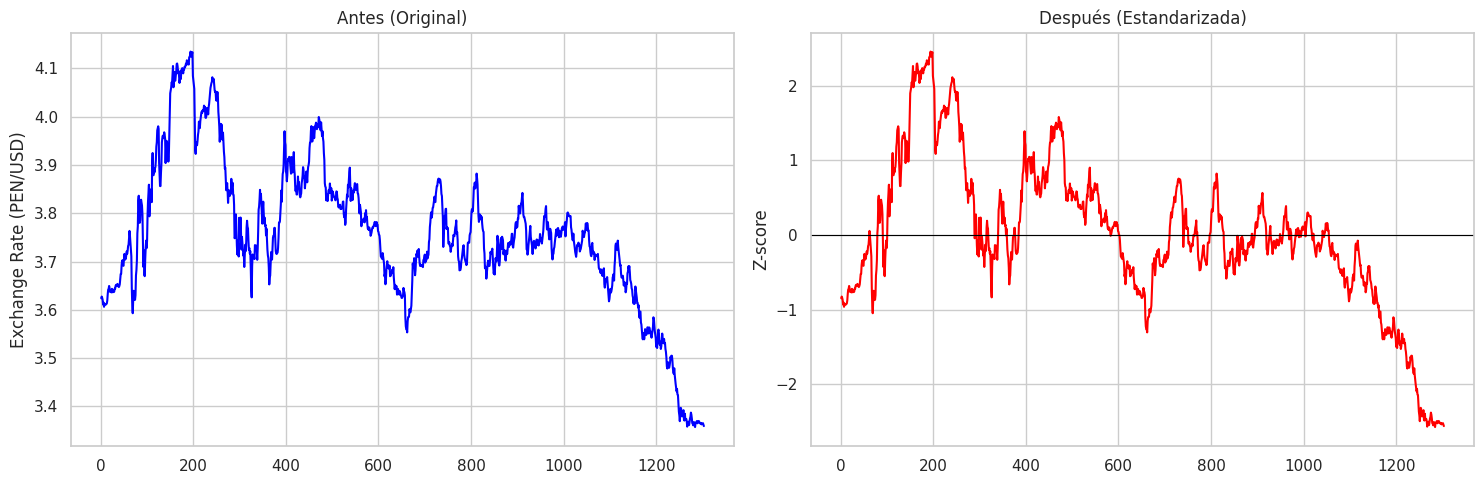

In [20]:
# --- Select variable ---
df_fx = (
    df_wide_clean[["fx_interbank"]]
    .dropna()
    .copy()
)

# --- Z-score standardization ---
mu = df_fx["fx_interbank"].mean()
sigma = df_fx["fx_interbank"].std()

df_fx["fx_interbank_std"] = (df_fx["fx_interbank"] - mu) / sigma

# --- Plot: Before vs After ---
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Before (original)
df_fx["fx_interbank"].plot(
    ax=ax[0],
    color="blue",
    title="Antes (Original)"
)
ax[0].set_ylabel("Exchange Rate (PEN/USD)")
ax[0].grid(True)

# After (standardized)
df_fx["fx_interbank_std"].plot(
    ax=ax[1],
    color="red",
    title="Después (Estandarizada)"
)
ax[1].axhline(0, color="black", linewidth=0.8)
ax[1].set_ylabel("Z-score")
ax[1].grid(True)

plt.tight_layout()
plt.show()

17. Find the day with the largest `|SPY_ret|` and **annotate it** in the returns plot (like the exercise).  


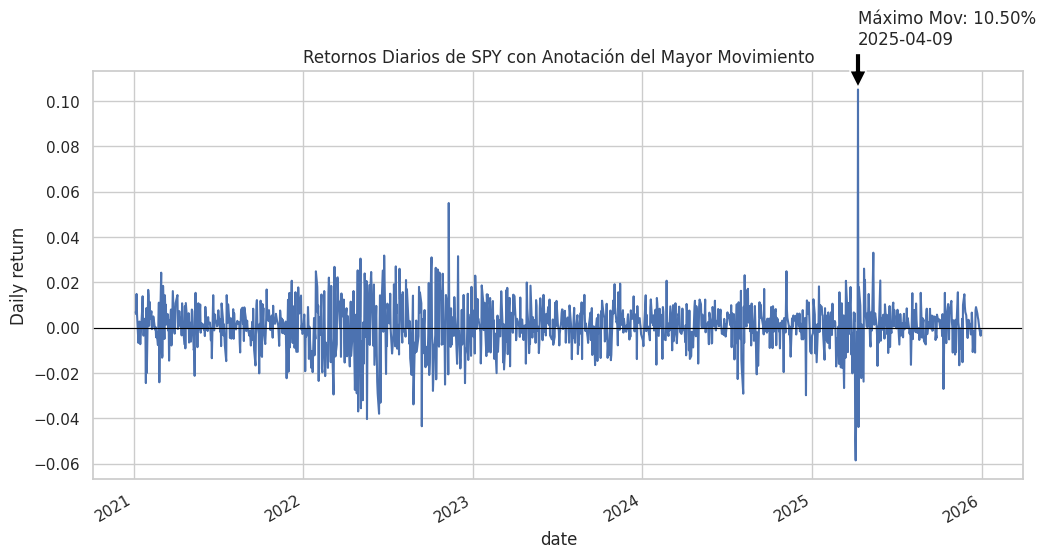

In [21]:
# --- SPY daily returns ---
spy_rets = (
    df_tidy_clean[df_tidy_clean["ticker"] == "SPY"]
    .set_index("date")["ret"]
)

# --- Largest absolute return ---
max_date = spy_rets.abs().idxmax()
max_ret = spy_rets.loc[max_date]

# --- Plot with annotation ---
plt.figure(figsize=(12, 6))
spy_rets.plot()

plt.annotate(
    f"Máximo Mov: {max_ret:.2%}\n{max_date.date()}",
    xy=(max_date, max_ret),
    xytext=(max_date, max_ret + 0.02),
    arrowprops=dict(facecolor="black", shrink=0.05)
)

plt.title("Retornos Diarios de SPY con Anotación del Mayor Movimiento")
plt.ylabel("Daily return")
plt.axhline(0, color="black", linewidth=0.8)
plt.grid(True)

plt.show()

18. Save one figure into `/figures` using `savefig` and verify the file exists.  


Archivo guardado: figures/precio_cobre.png
¿El archivo existe? True


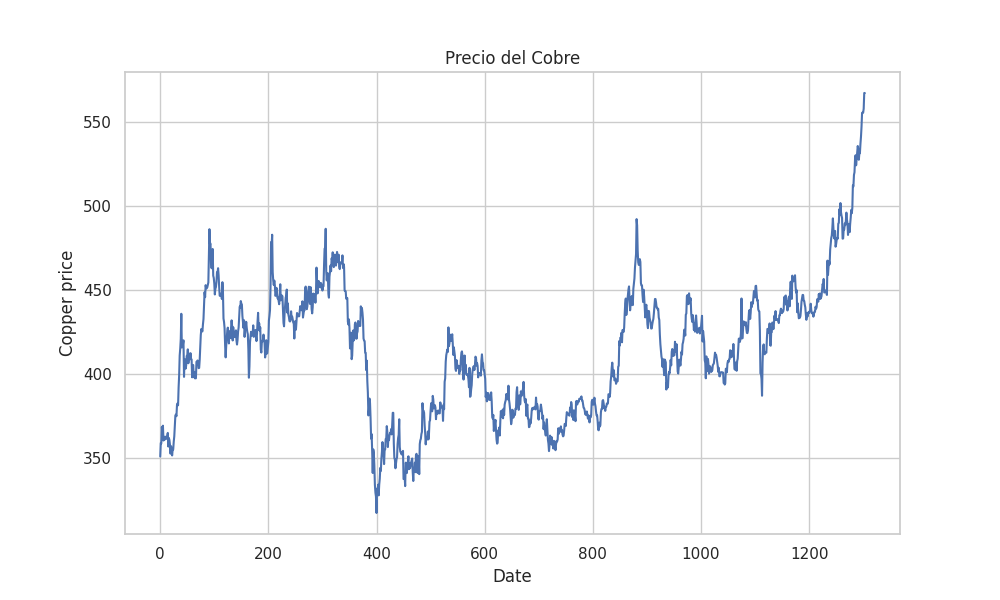

In [22]:
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display

# --- Create folder if it doesn't exist ---
os.makedirs("figures", exist_ok=True)

# --- Plot copper price ---
plt.figure(figsize=(10, 6))
df_wide_clean["copper"].dropna().plot(title="Precio del Cobre")
plt.xlabel("Date")
plt.ylabel("Copper price")
plt.grid(True)

# --- Save figure ---
file_path = "figures/precio_cobre.png"
plt.savefig(file_path)
plt.close()

# --- Verify file exists ---
print(f"Archivo guardado: {file_path}")
print("¿El archivo existe?", os.path.exists(file_path))

# Verify visually by loading saved file
display(Image(filename="figures/precio_cobre.png"))

19. Build a **summary stats table** for returns (mean, sd, p5, p95, etc.).  


In [23]:
# --- Pivot returns to wide format ---
df_ret_wide = (
    df_tidy_clean
    .pivot(index="date", columns="ticker", values="ret")
)

# --- Summary statistics ---
summary_stats = (
    df_ret_wide
    .describe(percentiles=[0.05, 0.50, 0.95])
    .T
)

# --- Select relevant statistics ---
summary_stats = summary_stats[
    ["mean", "std", "min", "5%", "50%", "95%", "max"]
]

print("Tabla de Estadísticas Resumidas:")
display(summary_stats)

Tabla de Estadísticas Resumidas:


,mean,std,min,5%,50%,95%,max
ticker,,,,,,,
GLD,0.00,0.01,-0.06,-0.02,0.00,0.02,0.04
SPY,0.00,0.01,-0.06,-0.02,0.00,0.02,0.11
TLT,-0.00,0.01,-0.03,-0.02,-0.00,0.02,0.04


20. Compute **historical 95% VaR** for a **60/40 portfolio (SPY/TLT)** and explain what it means.


In [24]:
# Portfolio returns: 60% SPY, 40% TLT
port_ret = 0.60 * df_ret_wide["SPY"] + 0.40 * df_ret_wide["TLT"]

# Historical VaR at 95% (5th percentile)
var_95 = port_ret.quantile(0.05)

print(f"VaR Histórico al 95% (60/40 SPY–TLT): {var_95:.2%}")
print(
    f"Interpretación: Con un 95% de confianza, la pérdida diaria del portafolio "
    f"no excederá aproximadamente {abs(var_95):.2%}. "
    f"Existe un 5% de probabilidad de perder más que ese valor en un día."
)

VaR Histórico al 95% (60/40 SPY–TLT): -1.27%
Interpretación: Con un 95% de confianza, la pérdida diaria del portafolio no excederá aproximadamente 1.27%. Existe un 5% de probabilidad de perder más que ese valor en un día.


# Assignment 3 (part 2)

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 120)

In [26]:
from __future__ import annotations

from pathlib import Path
import hashlib
import re
from io import StringIO

import numpy as np
import pandas as pd

# Configuration


CACHE_DIR = Path(".cache")
CACHE_DIR.mkdir(exist_ok=True)

# Cache utilities (parquet -> csv fallback)

def _hash_key(*parts: object) -> str:
    h = hashlib.sha256()
    for p in parts:
        h.update(str(p).encode("utf-8"))
        h.update(b"|")
    return h.hexdigest()[:24]

def _cache_paths(prefix: str, key: str) -> tuple[Path, Path]:
    p_parquet = CACHE_DIR / f"{prefix}_{key}.parquet"
    p_csv = CACHE_DIR / f"{prefix}_{key}.csv"
    return p_parquet, p_csv

def _read_cache_df(prefix: str, key: str) -> pd.DataFrame | None:
    p_parquet, p_csv = _cache_paths(prefix, key)
    if p_parquet.exists():
        try:
            return pd.read_parquet(p_parquet)
        except Exception:
            pass
    if p_csv.exists():
        try:
            return pd.read_csv(p_csv)
        except Exception:
            pass
    return None

def _write_cache_df(df: pd.DataFrame, prefix: str, key: str) -> None:
    p_parquet, p_csv = _cache_paths(prefix, key)
    try:
        df.to_parquet(p_parquet, index=False)
        return
    except Exception:
        pass
    try:
        df.to_csv(p_csv, index=False)
    except Exception:
        # If caching fails, ignore silently (no exceptions)
        return

# HTTP helpers

def http_get_text(url: str, timeout: int = 30, headers: dict | None = None) -> str:
    """
    Returns response text. Raises inside, but callers wrap in try/except (no exceptions to user).
    """
    import requests

    h = {
        "User-Agent": "Mozilla/5.0 (compatible; FinanceCourse/1.0)",
        "Accept": "*/*",
    }
    if headers:
        h.update(headers)

    r = requests.get(url, timeout=timeout, headers=h)
    r.raise_for_status()
    return r.text
# Numeric + returns helpers
def parse_number(x) -> float:
    """
    Robust number parser:
      - '3,367' -> 3.367 (comma decimal)
      - '1,234.56' -> 1234.56 (comma thousands)
    """
    if x is None:
        return np.nan
    s = str(x).strip()
    if s == "" or s.lower() in {"nan", "none"}:
        return np.nan

    if "," in s and "." in s:
        s = s.replace(",", "")
    elif "," in s and "." not in s:
        s = s.replace(",", ".")

    try:
        return float(s)
    except Exception:
        return np.nan

def pct_change(s: pd.Series) -> pd.Series:
    x = pd.to_numeric(s, errors="coerce")
    return x.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan)
# BCRP parsing

_SP2EN = {
    "Ene": "Jan", "Feb": "Feb", "Mar": "Mar", "Abr": "Apr", "May": "May", "Jun": "Jun",
    "Jul": "Jul", "Ago": "Aug", "Set": "Sep", "Sep": "Sep", "Oct": "Oct", "Nov": "Nov", "Dic": "Dec",
}

def _clean_bcrp_payload(txt: str) -> str:
    """
    BCRP sometimes returns "CSV" wrapped as HTML with <br> line breaks.
    Normalize to plain text with real newlines.
    """
    x = txt.replace("\r\n", "\n").replace("\r", "\n")
    x = x.replace("<br/>", "\n").replace("<br />", "\n").replace("<br>", "\n")
    x = re.sub(r"</?pre[^>]*>", "", x, flags=re.IGNORECASE)
    return x.strip()

def _detect_sep(header_line: str) -> str:
    return ";" if header_line.count(";") > header_line.count(",") else ","

def _parse_bcrp_date(s: pd.Series) -> pd.Series:
    """
    Parses common BCRP date formats:
      - Daily: 2022-01-03, 03Jan22, 03Ene22
      - Monthly: Jan22, Ene22, 2022-1, 2022-01
      - Yearly: 2022
    """
    x = s.astype(str).str.strip()
    x = x.str.replace(".", "", regex=False)

    y = x
    for k, v in _SP2EN.items():
        y = y.str.replace(k, v, regex=False)

    dt = pd.to_datetime(y, format="%Y-%m-%d", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%d%b%y", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%b%y", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%Y-%m", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%Y", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], errors="coerce")

    return dt


def bcrp_series_csv(
    series_codes: list[str],
    start: str,
    end: str,
    lang: str = "ing",
) -> pd.DataFrame:
    """
    BCRPData API (CSV):
      https://estadisticas.bcrp.gob.pe/estadisticas/series/api/[codes]/csv/[start]/[end]/[lang]

    Returns LONG DataFrame:
      date, series_name, value

    If the endpoint fails, prints a short message and returns an empty DataFrame (no exceptions).
    """
    codes = "-".join(series_codes)
    url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{codes}/csv/{start}/{end}/{lang}"

    key = _hash_key("bcrp", url)
    cached = _read_cache_df("bcrp", key)
    if cached is not None and cached.shape[0] > 0:
        cached["date"] = pd.to_datetime(cached["date"], errors="coerce")
        return cached

    try:
        txt = http_get_text(url, timeout=30)
        txt = _clean_bcrp_payload(txt)

        lines = [ln for ln in txt.split("\n") if ln.strip() != ""]
        if len(lines) < 2:
            print("[BCRP] Endpoint returned no usable rows. Continuing...")
            return pd.DataFrame(columns=["date", "series_name", "value"])

        sep = _detect_sep(lines[0])
        df = pd.read_csv(StringIO("\n".join(lines)), sep=sep)

        if df.shape[0] == 0 or df.shape[1] < 2:
            print("[BCRP] Returned an empty table. Continuing...")
            return pd.DataFrame(columns=["date", "series_name", "value"])

        date_col = df.columns[0]
        value_cols = list(df.columns[1:])

        out = df.melt(
            id_vars=[date_col],
            value_vars=value_cols,
            var_name="series_name",
            value_name="value_raw",
        ).rename(columns={date_col: "date"})

        out["date"] = _parse_bcrp_date(out["date"])
        out["value"] = out["value_raw"].map(parse_number)

        out = out.drop(columns=["value_raw"])
        out = out.dropna(subset=["date"]).sort_values(["series_name", "date"]).reset_index(drop=True)

        _write_cache_df(out, "bcrp", key)
        return out

    except Exception as e:
        print(f"[BCRP] Endpoint unavailable ({type(e).__name__}). Continuing...")
        return pd.DataFrame(columns=["date", "series_name", "value"])
# Yahoo Finance (yfinance)

def yfinance_download(tickers: list[str], start: str, end: str) -> pd.DataFrame:
    """
    Yahoo Finance via yfinance.
    Returns LONG DataFrame:
      date, ticker, close, volume, ret

    If the endpoint fails, prints a short message and returns an empty DataFrame (no exceptions).
    """
    try:
        import yfinance as yf
    except Exception:
        print("[yfinance] yfinance not installed/importable. Continuing...")
        return pd.DataFrame(columns=["date", "ticker", "close", "volume", "ret"])

    key = _hash_key("yfinance", " ".join(tickers), start, end)
    cached = _read_cache_df("yf", key)
    if cached is not None and cached.shape[0] > 0:
        cached["date"] = pd.to_datetime(cached["date"], errors="coerce")
        return cached

    try:
        data = yf.download(tickers=tickers, start=start, end=end, auto_adjust=False, progress=False)
        if data is None or data.shape[0] == 0:
            print("[yfinance] Returned no rows. Continuing...")
            return pd.DataFrame(columns=["date", "ticker", "close", "volume", "ret"])

        frames = []
        if isinstance(data.columns, pd.MultiIndex):
            for t in tickers:
                if t not in data.columns.get_level_values(1):
                    continue
                sub = data.xs(t, axis=1, level=1).copy()
                sub = sub.reset_index().rename(columns={"Date": "date", "Datetime": "date"})
                sub["ticker"] = t
                sub = sub.rename(columns={"Close": "close", "Volume": "volume"})
                frames.append(sub[["date", "ticker", "close", "volume"]])
            out = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
        else:
            out = data.reset_index().rename(columns={"Date": "date", "Datetime": "date"})
            out["ticker"] = tickers[0]
            out = out.rename(columns={"Close": "close", "Volume": "volume"})
            out = out[["date", "ticker", "close", "volume"]]

        out["date"] = pd.to_datetime(out["date"], errors="coerce")
        out["close"] = pd.to_numeric(out["close"], errors="coerce")
        out["volume"] = pd.to_numeric(out["volume"], errors="coerce")

        out = out.dropna(subset=["date", "close"]).sort_values(["ticker", "date"]).reset_index(drop=True)
        out["ret"] = out.groupby("ticker")["close"].apply(pct_change).reset_index(level=0, drop=True)

        _write_cache_df(out, "yf", key)
        return out

    except Exception as e:
        print(f"[yfinance] Endpoint unavailable ({type(e).__name__}). Continuing...")
        return pd.DataFrame(columns=["date", "ticker", "close", "volume", "ret"])

## 1) Load real financial data

If an endpoint is temporarily unavailable, this notebook prints a short message and continues

In [27]:
START_D = "2022-01-01"
END_D   = "2025-12-18"

peru = bcrp_series_csv(
    series_codes=["PD04637PD", "PD04639PD", "PD04704XD", "PD04701XD"],
    start=START_D,
    end=END_D,
    lang="ing"
)

usa = yfinance_download(["SPY", "TLT", "GLD"], start=START_D, end=END_D)

print("Peru rows:", peru.shape[0], "| USA rows:", usa.shape[0])

# show in English (wide + renamed)
peru_wide = (
    peru.pivot_table(index="date", columns="series_name", values="value", aggfunc="last")
        .reset_index()
        .sort_values("date")
)
peru_wide.columns.name = None

rename_map = {}
for c in peru_wide.columns:
    cl = str(c).lower()
    if "interbanc" in cl and ("tipo de cambio" in cl or "tc" in cl or "exchange" in cl):
        rename_map[c] = "fx_interbank_buy"
    elif "sbs" in cl and ("tipo de cambio" in cl or "tc" in cl or "exchange" in cl):
        rename_map[c] = "fx_sbs_buy"
    elif "oro" in cl or "gold" in cl:
        rename_map[c] = "gold_london"
    elif "cobre" in cl or "copper" in cl:
        rename_map[c] = "copper_london"

peru_wide = peru_wide.rename(columns=rename_map)
peru_wide.head()

Peru rows: 4136 | USA rows: 2982


,date,copper_london,gold_london,fx_interbank_buy,fx_sbs_buy
0,2022-01-03,439.62,1820.10,3.98,3.99
1,2022-01-04,438.17,1811.40,3.96,3.96
2,2022-01-05,443.52,1826.25,3.95,3.95
3,2022-01-06,433.86,1789.35,3.97,3.97
4,2022-01-07,436.13,1792.60,3.95,3.95


### 1.1) Quantities

#### Exercise 1.1 — FX level comparison (Peru)

**Tasks**
1. Filter `peru` to the two FX series (Interbank buy and SBS buy).
2. Pivot to wide format (`date` as index).
3. Plot both FX levels in the same line chart.
4. Create `spread = sbs - interbank` and plot it in a separate figure.

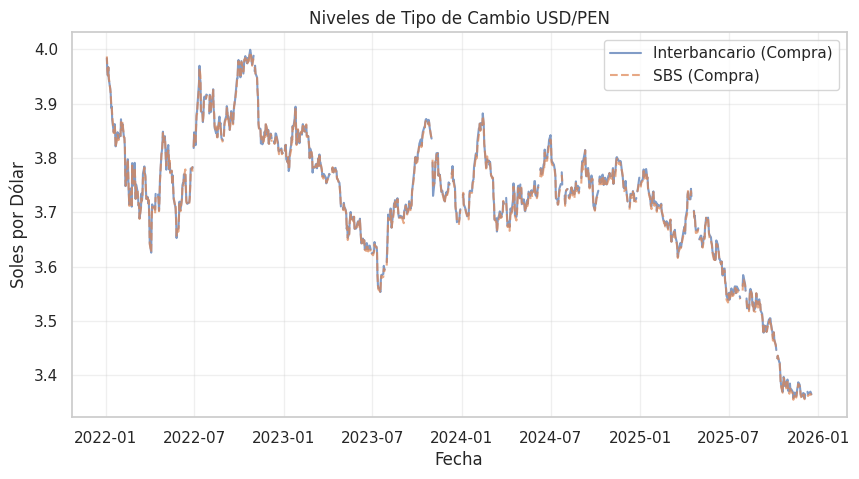

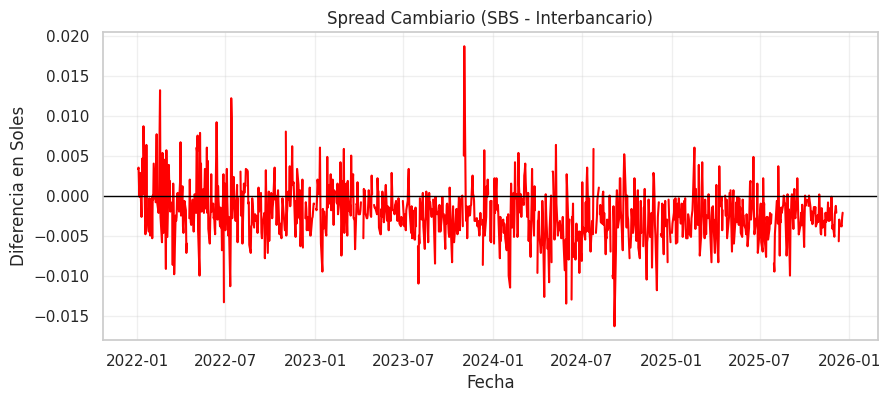

In [28]:
# Filter peru to the two FX series (Interbank buy and SBS buy).
fx_series_names = [
    "Tipo de cambio - TC Interbancario (S/ por US$) - Compra",
    "Tipo de cambio - TC Sistema bancario SBS (S/ por US$) - Compra"
]
peru_fx = peru[peru['series_name'].isin(fx_series_names)].copy()

# 2. Pivot to wide format (date as index).
peru_fx_wide = peru_fx.pivot(index='date', columns='series_name', values='value')

peru_fx_wide.columns = ['fx_interbank', 'fx_sbs']

# 3. Plot both FX levels in the same line chart.
plt.figure(figsize=(10, 5))
plt.plot(peru_fx_wide.index, peru_fx_wide['fx_interbank'], label='Interbancario (Compra)', alpha=0.7)
plt.plot(peru_fx_wide.index, peru_fx_wide['fx_sbs'], label='SBS (Compra)', alpha=0.7, linestyle='--')

plt.title('Niveles de Tipo de Cambio USD/PEN')
plt.xlabel('Fecha')
plt.ylabel('Soles por Dólar')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. Create spread = sbs - interbank and plot it in a separate figure.
peru_fx_wide['spread'] = peru_fx_wide['fx_sbs'] - peru_fx_wide['fx_interbank']

plt.figure(figsize=(10, 4))
plt.plot(peru_fx_wide.index, peru_fx_wide['spread'], color='red')

plt.title('Spread Cambiario (SBS - Interbancario)')
plt.xlabel('Fecha')
plt.ylabel('Diferencia en Soles')
plt.axhline(0, color='black', linewidth=1) # Referencia en cero
plt.grid(True, alpha=0.3)
plt.show()

### 1.2) Proportions

#### Exercise 1.2 — Share of positive-return days (USA)

Define a positive day as `ret > 0`.

**Tasks**
1. For each ticker in `usa`, compute the share of days with `ret > 0`.
2. Plot a bar chart of these shares.
3. Add labels (percent format) and a title.

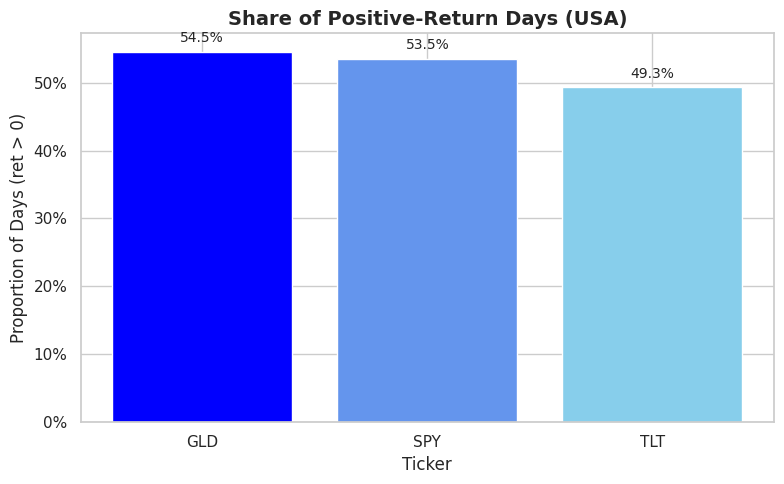

In [29]:
import matplotlib.ticker as mtick

# For each ticker in usa, compute the share of days with ret > 0.
positive_shares = (
    usa.groupby('ticker')['ret']
    .apply(lambda x: (x > 0).mean())
    .sort_values(ascending=False)
)

# 2. Plot a bar chart of these shares.
plt.figure(figsize=(8, 5))
bars = plt.bar(positive_shares.index, positive_shares.values, color=['blue', 'cornflowerBlue', 'skyblue'])

# 3. Add labels (percent format) and a title.
plt.title('Share of Positive-Return Days (USA)', fontsize=14, fontweight='bold')
plt.ylabel('Proportion of Days (ret > 0)', fontsize=12)
plt.xlabel('Ticker', fontsize=12)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2., 
        height + 0.01,                    
        f'{height:.1%}',                  
        ha='center', va='bottom', fontsize=10
    )

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.tight_layout()
plt.show()

### 1.3) Distributions

#### Exercise 1.3 — Return distributions: Peru Gold vs US Gold ETF

**Goal:** compare distributions of a **Peru gold reference price** series vs the **US gold ETF (GLD)**.

**Tasks**
1. From `peru`, build a daily gold series and compute returns.
2. From `usa`, filter to GLD returns.
3. Plot two histograms (separate figures) with the same binning.
4. Optional: overlay KDE for each distribution.

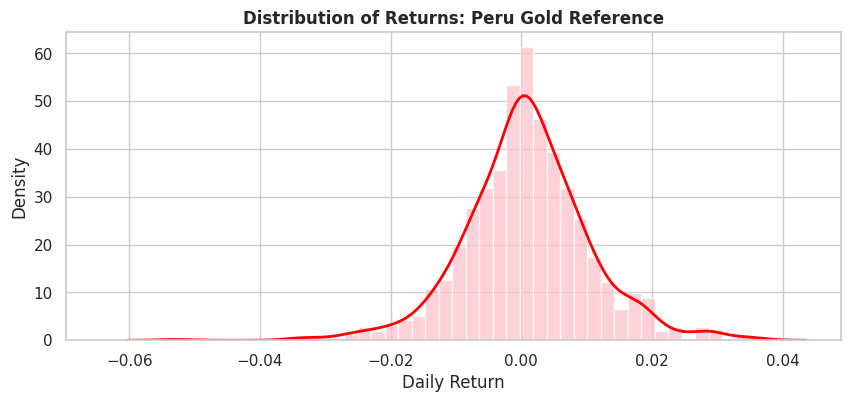

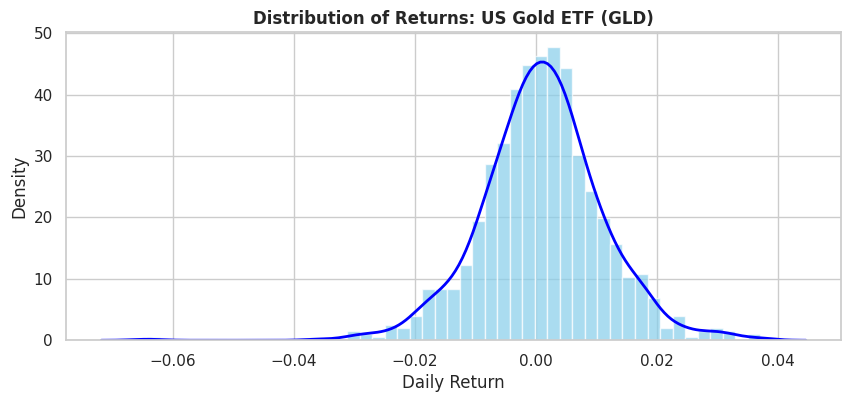

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. From peru, build a daily gold series and compute returns.
gold_series_name = peru[peru['series_name'].str.contains('Oro', case=False)]['series_name'].unique()[0]
peru_gold_ret = (
    peru[peru['series_name'] == gold_series_name]
    .sort_values('date')['value']
    .pct_change()
    .dropna()
)

# 2. From usa, filter to GLD returns.
usa_gold_ret = usa[usa['ticker'] == 'GLD']['ret'].dropna()

# 3. Plot two histograms (separate figures) with the same binning.
min_val = min(peru_gold_ret.min(), usa_gold_ret.min())
max_val = max(peru_gold_ret.max(), usa_gold_ret.max())
common_bins = np.linspace(min_val, max_val, 50)

# Figure 1: Peru Gold
plt.figure(figsize=(10, 4))
plt.hist(peru_gold_ret, bins=common_bins, color='pink', edgecolor='white', density=True, alpha=0.7)

sns.kdeplot(peru_gold_ret, color='red', linewidth=2)
plt.title('Distribution of Returns: Peru Gold Reference', fontweight='bold')
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.show()

# Figure 2: US Gold ETF (GLD)
plt.figure(figsize=(10, 4))
plt.hist(usa_gold_ret, bins=common_bins, color='skyblue', edgecolor='white', density=True, alpha=0.7)
# 4. Optional: overlay KDE
sns.kdeplot(usa_gold_ret, color='blue', linewidth=2)
plt.title('Distribution of Returns: US Gold ETF (GLD)', fontweight='bold')
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.show()

### 1.4) Relationships

#### Exercise 1.4 — FX changes vs market returns (Peru + USA)

Use:
- Peru interbank FX (daily % change)
- SPY returns (broad US market benchmark)

**Tasks**
1. Build interbank FX daily returns from the Peru FX series.
2. Build SPY daily returns from `usa`.
3. Merge on date.
4. Scatter plot (x = SPY ret, y = FX ret).
5. Compute correlation and write 2–3 sentences interpreting the sign/magnitude.

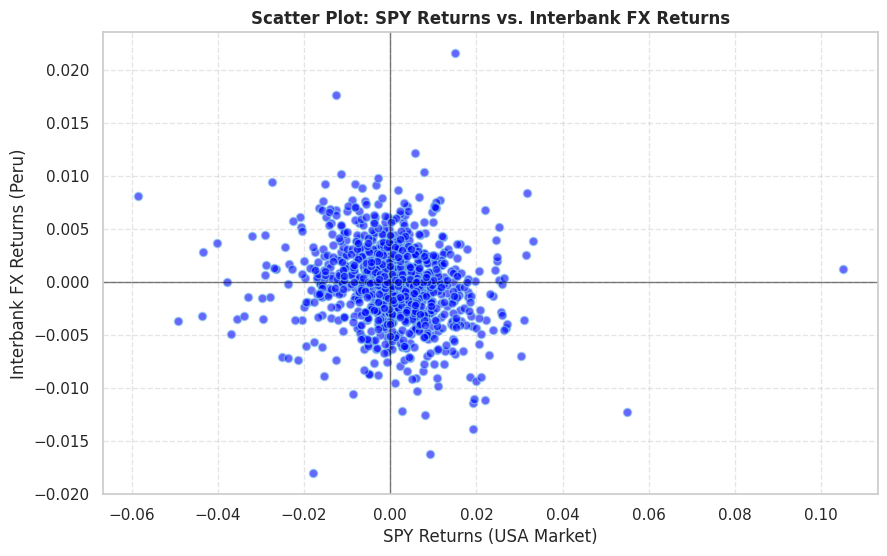

The correlation coefficient is: -0.1720
Interpretation:The negative correlation indicates that when the US stock market (SPY) rises,the Peruvian Sol tends to appreciate against the Dollar (negative FX return). This suggests a 'risk-on' environment where investors favor emerging market currencies when global equity markets are performing well.


In [31]:
# 1. Build interbank FX daily returns from the Peru FX series.
fx_interbank_name = "Tipo de cambio - TC Interbancario (S/ por US$) - Compra"
peru_fx_ret = (
    peru[peru['series_name'] == fx_interbank_name]
    .sort_values('date')
    .copy()
)
peru_fx_ret['fx_ret'] = peru_fx_ret['value'].pct_change()
peru_fx_ret = peru_fx_ret[['date', 'fx_ret']].dropna()

# 2. Build SPY daily returns from usa.
spy_ret = usa[usa['ticker'] == 'SPY'][['date', 'ret']].copy()
spy_ret.rename(columns={'ret': 'spy_ret'}, inplace=True)

# 3. Merge on date.
merged_df = pd.merge(peru_fx_ret, spy_ret, on='date')

# 4. Scatter plot (x = SPY ret, y = FX ret).
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['spy_ret'], merged_df['fx_ret'], color='blue', alpha=0.6, edgecolors='skyblue')

plt.axhline(0, color='black', linewidth=1, alpha=0.5)
plt.axvline(0, color='black', linewidth=1, alpha=0.5)

plt.title('Scatter Plot: SPY Returns vs. Interbank FX Returns', fontweight='bold')
plt.xlabel('SPY Returns (USA Market)')
plt.ylabel('Interbank FX Returns (Peru)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# 5. Compute correlation and write 2–3 sentences interpreting the sign/magnitude.
correlation = merged_df['spy_ret'].corr(merged_df['fx_ret'])
print(f"The correlation coefficient is: {correlation:.4f}")

# Interpretation: 
# The negative correlation indicates that when the US stock market (SPY) rises,the Peruvian Sol tends to appreciate against the Dollar (negative FX return). 
# This suggests a "risk-on" environment where investors favor emerging market currencies when global equity markets are performing well.

print(f"Interpretation:The negative correlation indicates that when the US stock market (SPY) rises,the Peruvian Sol tends to appreciate against the Dollar (negative FX return). This suggests a 'risk-on' environment where investors favor emerging market currencies when global equity markets are performing well.")

### 1.5) References 

- BCRP Statistical Series (Daily): exchange rates and commodities series catalog.
- BCRPData API (CSV endpoint) for downloading series.
- yfinance: Python wrapper that fetches historical market data from Yahoo Finance.

In [32]:
#6) References

#This project utilizes data and tools from the following sources:

#BCRP Statistical Series (Daily): Used to identify and catalog the specific codes for Peru's exchange rates (Interbank and SBS) and commodity reference prices (Gold and Copper).
#BCRPData API (CSV endpoint): The primary technical interface used to programmatically download historical time series data directly from the Central Reserve Bank of Peru.
#yfinance:A Python library that acts as a wrapper for the Yahoo Finance API, used to fetch historical market data for US assets, including SPY (Equities), TLT (Bonds), and GLD (Gold ETF).

## 2) Online Data Sources 

### Exercise 2.1 — Inspect the BCRPData API URL (requests)
You are already downloading from BCRPData. Now you will **inspect** what is being requested.

**Tasks**
1. Recreate the API URL string used to download the Peru series.
2. Print it.
3. Download the CSV text using `http_get_text` and display the first 10 lines.
4. Explain (in a markdown cell) what each part of the URL means.

In [33]:
from pathlib import Path
import time
import requests

# It defines a function that fetches raw text from a URL while mimicking a real web browser, 
# using a persistent session (requests.Session) and browser-like HTTP headers to avoid server 
# blocking (403 errors) from the BCRP website.
def fetch_text_with_session(url: str, timeout: int = 30, tries: int = 3) -> str:
    """Fetch raw text using a requests.Session (cookies) + browser-like headers."""
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/120.0.0.0 Safari/537.36"
        ),
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
        "Accept-Language": "en-US,en;q=0.9,es;q=0.8",
        "Referer": "https://estadisticas.bcrp.gob.pe/",
        "Connection": "keep-alive",
        "Cache-Control": "no-cache",
        "Pragma": "no-cache",
    }

    s = requests.Session()

# This code segment performs a warm-up request to obtain cookies and reduce the likelihood of 
# being blocked by the BCRP website. It then attempts to fetch the target URL multiple times, 
# handling possible 403 Forbidden errors by waiting and retrying. If a request succeeds, the raw 
# CSV text is returned; otherwise, the last error is raised. Overall, it provides a robust retry 
# mechanism to reliably access a protected web API.
    try:
        s.get("https://estadisticas.bcrp.gob.pe/", headers=headers, timeout=timeout)
    except Exception:
        pass

    last = None
    for k in range(tries):
        try:
            r = s.get(url, headers=headers, timeout=timeout)
            if r.status_code == 403:
                last = requests.HTTPError(f"403 Forbidden for url: {url}")
                time.sleep(1.5 * (k + 1))
                continue
            r.raise_for_status()
            return r.text
        except Exception as e:
            last = e
            time.sleep(1.5 * (k + 1))

    raise last


SERIES = ["PD04637PD", "PD04639PD", "PD04704XD", "PD04701XD"]

START_D = "2022-01-01"
END_D   = "2025-12-18"
LANG    = "ing"

# 1) This code dynamically builds the BCRP API URL to download multiple time series at once by joining 
# the series codes with hyphens and appending the date range and language. It then prints the final URL 
# so the user can visually verify it or test it directly in a browser.
codes = "-".join(SERIES)
url_multi = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{codes}/csv/{START_D}/{END_D}/{LANG}"

print("BCRPData URL (multi-series):")
print(url_multi)

# 2-3) Try to download raw CSV text and show first 10 lines
# Attempts to download the raw CSV text from the BCRP API and preview the first 10 lines
txt = None
raw_source = None

try:
    txt = fetch_text_with_session(url_multi, timeout=30, tries=3)
    raw_source = "server (multi-series)"
except Exception as e:
    print(f"[BCRP] Multi-series request failed: {type(e).__name__}: {e}")

# Fallback: try only ONE series (often allowed even if multi is blocked)
# If the multi-series request fails, retry using a single series code
if txt is None:
    one = SERIES[0]
    url_one = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{one}/csv/{START_D}/{END_D}/{LANG}"
    print("\nBCRPData URL (single-series fallback):")
    print(url_one)
    try:
        txt = fetch_text_with_session(url_one, timeout=30, tries=3)
        raw_source = f"server (single-series: {one})"
    except Exception as e:
        print(f"[BCRP] Single-series request failed: {type(e).__name__}: {e}")

if txt is not None:
    # Replace <br> HTML tags with newline characters (some responses use HTML breaks)
    # Cleans the response so it behaves like a standard CSV text
    txt_clean = (txt.replace("<br />", "\n").replace("<br/>", "\n").replace("<br>", "\n"))

    lines = txt_clean.splitlines()
    print(f"\nFirst 10 lines of the response ({raw_source}):")
    for i, line in enumerate(lines[:10], start=1):
        print(f"{i:02d}: {line}")

else:
    # Last-resort fallback: reconstruct "CSV-like" lines from your cached dataframes
    # If downloading fails completely, recreate a preview using locally stored data
    # NOTE: this is NOT the raw server response; it's reconstructed from local data.
    print("\n[BCRP] Could not fetch raw text due to 403. Reconstructing lines from local data (NOT raw server response).")

    # Try to use peru_w if it exists; else use peru if it exists.
    # Uses previously downloaded dataframes as a visual substitute
    if "peru_w" in globals() and hasattr(peru_w, "head"):
        preview = peru_w.head(10).to_csv(index=False)
        rec_lines = preview.splitlines()[:10]
        print("\nFirst 10 lines (reconstructed from peru_w):")
        for i, line in enumerate(rec_lines, start=1):
            print(f"{i:02d}: {line}")
    elif "peru" in globals() and hasattr(peru, "head"):
        preview = peru.head(10).to_csv(index=False)
        rec_lines = preview.splitlines()[:10]
        print("\nFirst 10 lines (reconstructed from peru):")
        for i, line in enumerate(rec_lines, start=1):
            print(f"{i:02d}: {line}")
    else:
        print("No local dataframes found (peru/peru_w). Run the download cells first.")

BCRPData URL (multi-series):
https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PD04637PD-PD04639PD-PD04704XD-PD04701XD/csv/2022-01-01/2025-12-18/ing

First 10 lines of the response (server (multi-series)):
01: D&iacute;a/Mes/A&ntilde;o,"Tipo de cambio - TC Interbancario (S/ por US$) - Compra","Tipo de cambio - TC Sistema bancario SBS (S/ por US$) - Compra","Cotizaciones internacionales - Cobre (Londres, cUS$ por libras)","Cotizaciones internacionales - Oro (Londres, US$ por onzas troy)"
02: "03.Jan.22","3.98366666666667","3.987","439.621724973844","1820.1"
03: "04.Jan.22","3.9595","3.963","438.170229389944","1811.4"
04: "05.Jan.22","3.952","3.953","443.522619355577","1826.25"
05: "06.Jan.22","3.96716666666667","3.967","433.86110187524","1789.35"
06: "07.Jan.22","3.94516666666667","3.948","436.129063725084","1792.6"
07: "10.Jan.22","3.92766666666667","3.925","438.397025574929","1794.2"
08: "11.Jan.22","3.91633333333333","3.919","438.260947863938","1806.8"
09: "12.Jan.22","3.89233

#### 4. Explain (in a markdown cell) what each part of the URL means.

URL components

https://estadisticas.bcrp.gob.pe: Base domain of the Central Reserve Bank of Peru (BCRP) statistics website.

/estadisticas/series/api/: Path that points to the BCRP API used to download time series data.

PD04637PD-PD04639PD-PD04704XD-PD04701XD: List of series codes requested, separated by hyphens.
Each code uniquely identifies an economic or financial time series in the BCRP database.

/csv/: Specifies the output format of the data. In this case, the data is returned as a CSV file.

2022-01-01: Start date of the requested data range (YYYY-MM-DD).

2025-12-18: End date of the requested data range (YYYY-MM-DD).

ing: Language of the metadata and headers in the response (ing = English).

### Exercise 2.2 — Build a clean wide table (Peru finance data)
Turn long BCRP data into a clean table.

**Tasks**
1. Use `peru_w` (already wide).
2. Rename columns to short names:
   - `fx_interbank`, `fx_sbs`, `gold`, `copper`
   (Hint: inspect column names first.)
3. Create daily percentage changes for FX and commodities.
4. Drop rows where all four returns are missing.

In [34]:
import html
from io import StringIO

# 1-2) This code downloads data from the BCRP API, cleans and standardizes column names, 
# fixes date formatting, and builds a wide DataFrame (peru_w) ready for analysis. This 
# fully covers points 1 and 2 of the exercise (create peru_w and rename columns).

# --- Convert raw CSV text into DataFrame ---
peru = pd.read_csv(StringIO(txt_clean))

# --- Decode HTML entities in column names ---
peru.columns = [html.unescape(c) for c in peru.columns]

# --- Rename columns to short, usable names ---
peru = peru.rename(columns={
    "Día/Mes/Año": "date",
    "Tipo de cambio - TC Interbancario (S/ por US$) - Compra": "fx_interbank",
    "Tipo de cambio - TC Sistema bancario SBS (S/ por US$) - Compra": "fx_sbs",
    "Cotizaciones internacionales - Cobre (Londres, cUS$ por libras)": "copper",
    "Cotizaciones internacionales - Oro (Londres, US$ por onzas troy)": "gold",
})

# --- Translate Spanish month abbreviations to English ---
peru["date"] = (
    peru["date"]
    .str.replace("Ene", "Jan", regex=False)
    .str.replace("Feb", "Feb", regex=False)
    .str.replace("Mar", "Mar", regex=False)
    .str.replace("Abr", "Apr", regex=False)
    .str.replace("May", "May", regex=False)
    .str.replace("Jun", "Jun", regex=False)
    .str.replace("Jul", "Jul", regex=False)
    .str.replace("Ago", "Aug", regex=False)
    .str.replace("Set", "Sep", regex=False)
    .str.replace("Oct", "Oct", regex=False)
    .str.replace("Nov", "Nov", regex=False)
    .str.replace("Dic", "Dec", regex=False)
)

# --- Parse date column safely ---
peru["date"] = pd.to_datetime(peru["date"], format="%d.%b.%y")

# --- Build wide DataFrame (this is peru_w) ---
peru_w = (
    peru
    .set_index("date")
    .sort_index()
)

# --- Final check ---
print(peru_w.head())
print(peru_w.columns)

                fx_interbank fx_sbs  copper    gold
date                                               
2022-01-03  3.98366666666667  3.987  439.62 1820.10
2022-01-04            3.9595  3.963  438.17 1811.40
2022-01-05             3.952  3.953  443.52 1826.25
2022-01-06  3.96716666666667  3.967  433.86 1789.35
2022-01-07  3.94516666666667  3.948  436.13 1792.60
Index(['fx_interbank', 'fx_sbs', 'copper', 'gold'], dtype='object')


In [35]:
# 3) First, we ensure that all price series are converted to numeric format to avoid 
# arithmetic errors. Then, daily percentage changes (returns) are computed for each series.
df_wide = peru_w.copy()

price_cols = ["fx_interbank", "fx_sbs", "gold", "copper"]

for col in price_cols:
    df_wide[col] = pd.to_numeric(df_wide[col], errors="coerce")

for col in price_cols:
    df_wide[f"{col}_ret"] = df_wide[col].pct_change()

In [36]:
# 4) Rows where all return values are missing are removed, keeping observations with at least 
# one available return.
ret_cols = [
    "fx_interbank_ret",
    "fx_sbs_ret",
    "gold_ret",
    "copper_ret",
]

df_wide_clean = df_wide.dropna(subset=ret_cols, how="all")

df_wide_clean.head()

,fx_interbank,fx_sbs,copper,gold,fx_interbank_ret,fx_sbs_ret,gold_ret,copper_ret
date,,,,,,,,
2022-01-04,3.96,3.96,438.17,1811.40,-0.01,-0.01,-0.00,-0.00
2022-01-05,3.95,3.95,443.52,1826.25,-0.00,-0.00,0.01,0.01
2022-01-06,3.97,3.97,433.86,1789.35,0.00,0.00,-0.02,-0.02
2022-01-07,3.95,3.95,436.13,1792.60,-0.01,-0.00,0.00,0.01
2022-01-10,3.93,3.92,438.40,1794.20,-0.00,-0.01,0.00,0.01


## 3) Matplotlib: Constructing the Plot 

### Exercise 3.1 
Create a single figure with 2 subplots:
- Top: Peru FX spread (SBS - interbank)
- Bottom: USA SPY close price

**Tasks**
1. Build the Peru FX spread series from `peru_w`.
2. Build SPY close series from `usa_w`.
3. Use `plt.subplots(nrows=2, ncols=1, sharex=True)`.
4. Add titles, axis labels, and use `fig.tight_layout()`.

In [37]:
import numpy as np
import pandas as pd
import requests
import re
from io import StringIO

# ---------- helpers ----------
_SP2EN = {
    "Ene": "Jan", "Feb": "Feb", "Mar": "Mar", "Abr": "Apr", "May": "May", "Jun": "Jun",
    "Jul": "Jul", "Ago": "Aug", "Set": "Sep", "Sep": "Sep", "Oct": "Oct", "Nov": "Nov", "Dic": "Dec",
}

def parse_number(x) -> float:
    if x is None:
        return np.nan
    s = str(x).strip()
    if s == "" or s.lower() in {"nan", "none"}:
        return np.nan
    if "," in s and "." in s:
        s = s.replace(",", "")
    elif "," in s and "." not in s:
        s = s.replace(",", ".")
    try:
        return float(s)
    except Exception:
        return np.nan

def _clean_bcrp_payload(txt: str) -> str:
    x = txt.replace("\r\n", "\n").replace("\r", "\n")
    x = x.replace("<br/>", "\n").replace("<br />", "\n").replace("<br>", "\n")
    x = re.sub(r"</?pre[^>]*>", "", x, flags=re.IGNORECASE)
    return x.strip()

def _detect_sep(header_line: str) -> str:
    return ";" if header_line.count(";") > header_line.count(",") else ","

def _parse_bcrp_date(s: pd.Series) -> pd.Series:
    x = s.astype(str).str.strip().str.replace(".", "", regex=False)
    y = x
    for k, v in _SP2EN.items():
        y = y.str.replace(k, v, regex=False)

    dt = pd.to_datetime(y, format="%Y-%m-%d", errors="coerce")
    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%d%b%y", errors="coerce")
    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%b%y", errors="coerce")
    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], errors="coerce")
    return dt

def bcrp_series_csv(series_codes, start, end, lang="ing"):
    codes = "-".join(series_codes)
    url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{codes}/csv/{start}/{end}/{lang}"
    r = requests.get(url, timeout=30, headers={"User-Agent":"Mozilla/5.0"})
    r.raise_for_status()
    txt = _clean_bcrp_payload(r.text)

    lines = [ln for ln in txt.split("\n") if ln.strip() != ""]
    sep = _detect_sep(lines[0])
    df = pd.read_csv(StringIO("\n".join(lines)), sep=sep)

    date_col = df.columns[0]
    value_cols = list(df.columns[1:])

    out = df.melt(
        id_vars=[date_col],
        value_vars=value_cols,
        var_name="series_name",
        value_name="value_raw",
    ).rename(columns={date_col: "date"})

    out["date"] = _parse_bcrp_date(out["date"])
    out["value"] = out["value_raw"].map(parse_number)
    out = out.drop(columns=["value_raw"]).dropna(subset=["date"]).sort_values(["series_name","date"]).reset_index(drop=True)
    return out

# ---------- download Peru data ----------
START_D = "2022-01-01"
END_D   = "2025-12-18"

peru = bcrp_series_csv(
    series_codes=["PD04637PD", "PD04639PD", "PD04704XD", "PD04701XD"],
    start=START_D,
    end=END_D,
    lang="ing"
)

# ---------- make wide + rename ----------
peru_wide = (
    peru.pivot_table(index="date", columns="series_name", values="value", aggfunc="last")
        .reset_index()
        .sort_values("date")
)
peru_wide.columns.name = None

rename_map = {}
for c in peru_wide.columns:
    cl = str(c).lower()
    if "interbanc" in cl and ("compra" in cl or "buy" in cl):
        rename_map[c] = "fx_interbank_buy"
    elif "sbs" in cl and ("compra" in cl or "buy" in cl):
        rename_map[c] = "fx_sbs_buy"
    elif "oro" in cl or "gold" in cl:
        rename_map[c] = "gold_london"
    elif "cobre" in cl or "copper" in cl:
        rename_map[c] = "copper_london"

peru_wide = peru_wide.rename(columns=rename_map)

print("OK - peru rows:", peru.shape[0])
print("Columns:", list(peru_wide.columns))
peru_wide.head()


OK - peru rows: 4136
Columns: ['date', 'copper_london', 'gold_london', 'fx_interbank_buy', 'fx_sbs_buy']


,date,copper_london,gold_london,fx_interbank_buy,fx_sbs_buy
0,2022-01-03,439.62,1820.10,3.98,3.99
1,2022-01-04,438.17,1811.40,3.96,3.96
2,2022-01-05,443.52,1826.25,3.95,3.95
3,2022-01-06,433.86,1789.35,3.97,3.97
4,2022-01-07,436.13,1792.60,3.95,3.95


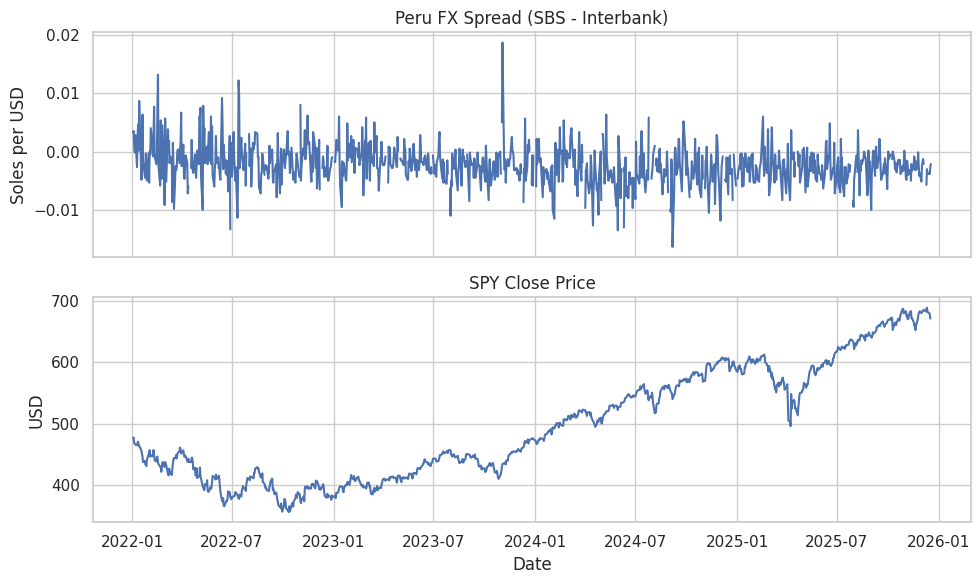

In [38]:
import matplotlib.pyplot as plt

# Spread Peru
peru_fx = peru_wide[["date","fx_sbs_buy","fx_interbank_buy"]].copy()
peru_fx["fx_spread"] = peru_fx["fx_sbs_buy"] - peru_fx["fx_interbank_buy"]

# SPY close (usa debe existir)
spy_close = (
    usa.loc[usa["ticker"]=="SPY", ["date","close"]]
       .dropna()
       .sort_values("date")
)

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,6))

axes[0].plot(peru_fx["date"], peru_fx["fx_spread"])
axes[0].set_title("Peru FX Spread (SBS - Interbank)")
axes[0].set_ylabel("Soles per USD")

axes[1].plot(spy_close["date"], spy_close["close"])
axes[1].set_title("SPY Close Price")
axes[1].set_ylabel("USD")
axes[1].set_xlabel("Date")

fig.tight_layout()
plt.show()


### Exercise 3.2 — Annotations (mark a key event on a series)
Annotate the largest absolute daily SPY return.

**Tasks**
1. Find the date with the largest `abs(ret)` for SPY.
2. Plot SPY returns over time.
3. Add an annotation at the extreme point (arrow + text).

In [39]:
import yfinance as yf
import pandas as pd

START_D = "2022-01-01"
END_D   = "2025-12-18"

# Download data
data = yf.download(
    ["SPY", "TLT", "GLD"],
    start=START_D,
    end=END_D,
    auto_adjust=False,
    progress=False
)

frames = []
for t in ["SPY", "TLT", "GLD"]:
    sub = data.xs(t, axis=1, level=1).reset_index()
    sub["ticker"] = t
    sub = sub.rename(columns={"Date": "date", "Close": "close", "Volume": "volume"})
    frames.append(sub[["date", "ticker", "close", "volume"]])

usa = (
    pd.concat(frames, ignore_index=True)
      .sort_values(["ticker", "date"])
      .reset_index(drop=True)
)

# Compute returns
usa["ret"] = usa.groupby("ticker")["close"].pct_change(fill_method=None)

print("OK - usa created")
usa.head()


OK - usa created


Price,date,ticker,close,volume,ret
0,2022-01-03,GLD,168.33,9014400,NaN
1,2022-01-04,GLD,169.57,6965600,0.01
2,2022-01-05,GLD,169.06,8715600,-0.00
3,2022-01-06,GLD,166.99,10902700,-0.01
4,2022-01-07,GLD,167.75,8191900,0.00


Largest |SPY return|
Date: 2025-04-09 00:00:00
Return: 0.10501930183911301


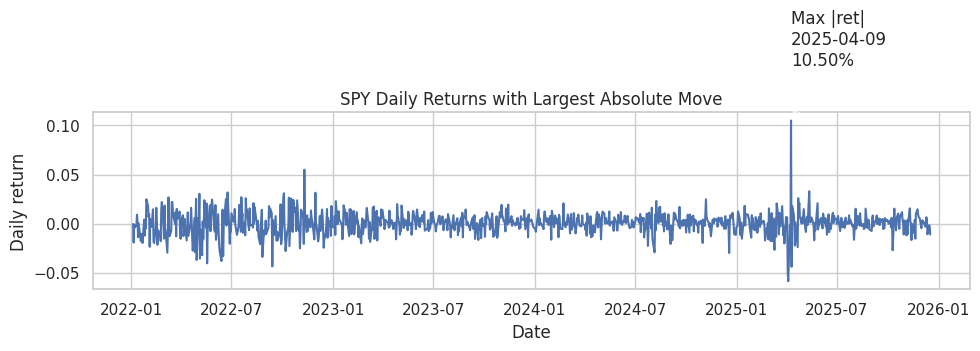

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# 1) Filter SPY returns
spy_ret = (
    usa.loc[usa["ticker"] == "SPY", ["date", "ret"]]
       .dropna()
       .sort_values("date")
       .reset_index(drop=True)
)

# 2) Find date with largest absolute return
idx_ext = spy_ret["ret"].abs().idxmax()
ext_date = spy_ret.loc[idx_ext, "date"]
ext_ret  = spy_ret.loc[idx_ext, "ret"]

print("Largest |SPY return|")
print("Date:", ext_date)
print("Return:", ext_ret)

# 3) Plot SPY returns
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(spy_ret["date"], spy_ret["ret"])
ax.set_title("SPY Daily Returns with Largest Absolute Move")
ax.set_xlabel("Date")
ax.set_ylabel("Daily return")

# 4) Annotation
ax.annotate(
    f"Max |ret|\n{ext_date.date()}\n{ext_ret:.2%}",
    xy=(ext_date, ext_ret),
    xytext=(ext_date, ext_ret * 1.5),
    arrowprops=dict(arrowstyle="->"),
    ha="left",
    va="bottom"
)

fig.tight_layout()
plt.show()


### Exercise 3.3 — Saving the figure
Save one of your figures to disk.

**Tasks**
1. Create a folder `figures/` if it does not exist.
2. Save the subplot figure as `figures/lecture4II_fx_spy.png` with dpi=150.
3. Confirm the file exists.

In [41]:
from pathlib import Path

# 1) Create folder 'figures/' if it does not exist
figures_dir = Path("figures")
figures_dir.mkdir(exist_ok=True)

# 2) Save the figure
file_path = figures_dir / "lecture4II_fx_spy.png"
fig.savefig(file_path, dpi=150)

# 3) Confirm the file exists
file_path.exists()


True

## 4) Statistics 
### Exercise 4.1 — Summary statistics table (returns)
Build a clean table of return moments.

**Tasks**
1. Create a wide daily returns table for SPY, TLT, GLD.
2. Compute: mean, std, skewness, kurtosis.
3. Present results as a DataFrame with tickers as rows.

In [42]:
# 1. Create wide returns table
df_returns_wide = usa.pivot(index='date', columns='ticker', values='ret').dropna()

# 2. & 3. Compute moments and present as DataFrame
summary_stats = pd.DataFrame({
    'Mean': df_returns_wide.mean(),
    'Std Dev': df_returns_wide.std(),
    'Skewness': df_returns_wide.skew(),
    'Kurtosis': df_returns_wide.kurtosis()
})

display(summary_stats)

,Mean,Std Dev,Skewness,Kurtosis
ticker,,,,
GLD,0.00,0.01,-0.20,2.40
SPY,0.00,0.01,0.37,9.03
TLT,-0.00,0.01,0.01,0.37


### Exercise 4.2 — 
Run a simple regression of GLD returns on SPY returns:

\[
GLD_t = \alpha + \beta\,SPY_t + \varepsilon_t
\]

**Tasks**
1. Build aligned return vectors (drop missing).
2. Compute \alpha and \beta using the closed-form OLS formulas.
3. Plot the scatter and fitted line.
4. Interpret \beta in 2–3 sentences.

Alpha: 0.000879
Beta: 0.1019


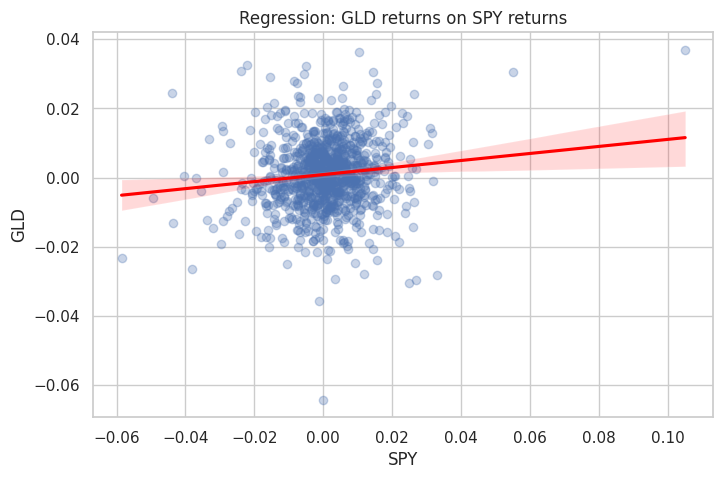

In [43]:
# 1. Aligned vectors
x = df_returns_wide['SPY']
y = df_returns_wide['GLD']

# 2. Closed-form OLS formulas
beta = np.cov(x, y)[0, 1] / np.var(x)
alpha = y.mean() - beta * x.mean()

print(f"Alpha: {alpha:.6f}")
print(f"Beta: {beta:.4f}")

# 3. Plot
plt.figure(figsize=(8, 5))
sns.regplot(x=x, y=y, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title("Regression: GLD returns on SPY returns")
plt.show()

# 4. Interpretation
# The beta coefficient measures the sensitivity of Gold to S&P 500 movements. 
# A low beta suggests that GLD is a good diversifier, as its returns are not 
# heavily driven by the systematic risk of the US equity market.

## 5) Risk and Uncertainty 

### Exercise 5.1 — Historical VaR (95%) for a 60/40 portfolio
Portfolio:
- 60% SPY
- 40% TLT

**Tasks**
1. Create a wide returns table for SPY and TLT.
2. Compute portfolio daily returns.
3. Compute 1-day 95% Historical VaR (the 5th percentile of returns).
4. Compute 1-day 95% CVaR (average return below the 5th percentile).

In [44]:
# Step 1: Filter returns table to SPY and TLT columns
df_returns_wide_sp = df_returns_wide[['SPY', 'TLT']].dropna()

# Preview the returns table
print("Returns table (first 10 days):")
print(df_returns_wide_sp.head(10))

# Step 2: Compute portfolio daily returns (60% SPY + 40% TLT)
port_ret = 0.60 * df_returns_wide_sp['SPY'] + 0.40 * df_returns_wide_sp['TLT']

# Preview portfolio returns
print("\nPortfolio returns (first 10 days):")
print(port_ret.head(10))
print(f"\nTotal observations: {len(port_ret)}")

Returns table (first 10 days):
ticker       SPY   TLT
date                  
2022-01-04 -0.00 -0.00
2022-01-05 -0.02 -0.01
2022-01-06 -0.00  0.00
2022-01-07 -0.00 -0.01
2022-01-10 -0.00  0.00
2022-01-11  0.01  0.01
2022-01-12  0.00 -0.00
2022-01-13 -0.01  0.01
2022-01-14  0.00 -0.02
2022-01-18 -0.02 -0.01

Portfolio returns (first 10 days):
date
2022-01-04   -0.00
2022-01-05   -0.01
2022-01-06    0.00
2022-01-07   -0.01
2022-01-10    0.00
2022-01-11    0.01
2022-01-12    0.00
2022-01-13   -0.00
2022-01-14   -0.01
2022-01-18   -0.02
dtype: float64

Total observations: 993


VaR 95% (daily): -0.0137 (-1.37%)
CVaR 95% (daily): -0.0186 (-1.86%)

Interpretation VaR: With 95% confidence, the maximum daily expected loss is 1.37%
Interpretation CVaR: In the worst 5% of cases, the average loss is 1.86%


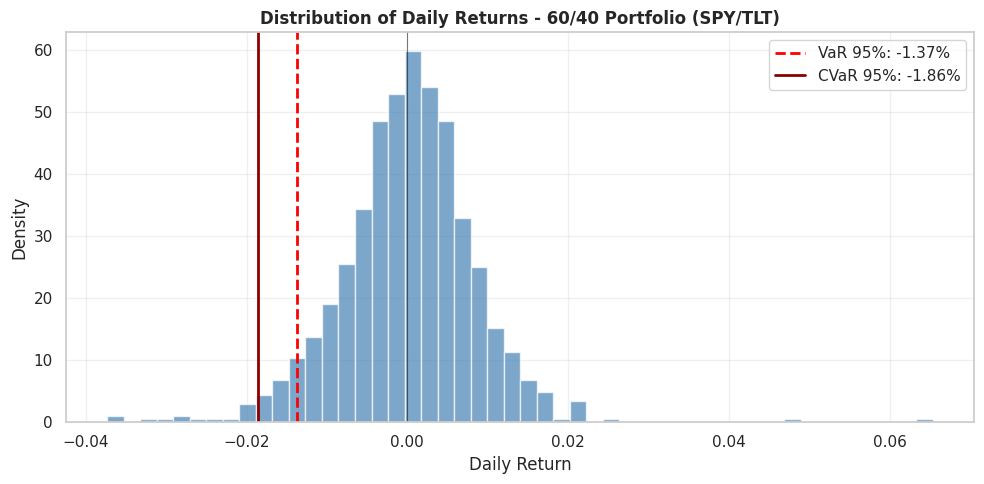

In [45]:
# Step 3: Compute 1-day 95% Historical VaR (5th percentile of returns)
var_95 = port_ret.quantile(0.05)

# Step 4: Compute 1-day 95% CVaR (average return below the VaR threshold)
cvar_95 = port_ret[port_ret <= var_95].mean()

# Display results
print(f"VaR 95% (daily): {var_95:.4f} ({var_95:.2%})")
print(f"CVaR 95% (daily): {cvar_95:.4f} ({cvar_95:.2%})")
print(f"\nInterpretation VaR: With 95% confidence, the maximum daily expected loss is {abs(var_95):.2%}")
print(f"Interpretation CVaR: In the worst 5% of cases, the average loss is {abs(cvar_95):.2%}")

# Visualization of VaR and CVaR
plt.figure(figsize=(10, 5))

# Plot histogram of portfolio returns
plt.hist(port_ret, bins=50, color='steelblue', edgecolor='white', alpha=0.7, density=True)

# Add vertical line for VaR (dashed red)
plt.axvline(var_95, color='red', linewidth=2, linestyle='--', label=f'VaR 95%: {var_95:.2%}')

# Add vertical line for CVaR (solid dark red)
plt.axvline(cvar_95, color='darkred', linewidth=2, linestyle='-', label=f'CVaR 95%: {cvar_95:.2%}')

# Add reference line at zero
plt.axvline(0, color='black', linewidth=0.8, alpha=0.5)

plt.title('Distribution of Daily Returns - 60/40 Portfolio (SPY/TLT)', fontweight='bold')
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


 **VaR (Value at Risk) at 95%**:
 - Indicates that, with 95% confidence, the maximum daily portfolio loss will not exceed the calculated value.
 - In other words, there is a 5% probability of losing more than this value in a single day.

 **CVaR (Conditional VaR) or Expected Shortfall**:
 - Represents the average loss in the worst scenarios (the bottom 5% of cases).
 - It is a more conservative measure than VaR, as it captures the tail risk of the distribution.


## 6) References

- BCRPData API (CSV endpoint): BCRP statistical series API for downloading time series
- BCRP series catalog: codes for FX (interbank/SBS) and commodity reference prices
- yfinance: Python wrapper to access historical market data from Yahoo Finance